<a href="https://colab.research.google.com/github/shubhamscifi/Instacart-Market-Basket-Analysis/blob/main/6.%20First-Cut%20Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[Instacart Market Basket Analysis](https://www.kaggle.com/c/instacart-market-basket-analysis/)**

---
- Given order_id predict all the products that the user will reorder.

---








## Importing libraries

In [ ]:
import plotly
import plotly.express as px
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re
import gc   # garbage collector
import pickle
# https://pypi.org/project/tqdm/#:~:text=jupyter%20console.%20Use-,auto,-instead%20of%20autonotebook
from tqdm.auto import tqdm
import time
from joblib import Parallel, delayed
from sklearn.metrics import f1_score,confusion_matrix,\
                            precision_recall_fscore_support,classification_report,\
                            accuracy_score,log_loss
from sklearn.model_selection import train_test_split

bold = lambda string: '\033[1m'+string+'\033[0m'    # for bold text
printb = lambda string: print('\033[1m'+string+'\033[0m')
# https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python/8930747

## Kaggle file uploader utility:
- To upload intermediate tables.

In [ ]:
def kaggle_file_uploader(files,id='shubhamscifi/instacart',title='instacart',folder='data',msg='',first_time=False,del_after_upload=True):
    '''Uploads list of files to kaggle.
    Note: make sure to run after kaggle authentication.
    id : must be between 6-50 chars after "username/".
    title : must be between 6-50 chars.
    files : list of path of files that are to be uploaded.
    first_time: True if the data is being uploaded for the first time.
    del_after_upload: True if given folder needs to be deleted after file upload finishes.'''
    # https://github.com/Kaggle/kaggle-api

    # create data package json file
    !mkdir {folder}
    !kaggle datasets init -p {folder}

    # preparing metadata json file
    import json,os
    metadata = open(os.path.join(folder,'dataset-metadata.json'),'r+')
    meta = json.load(metadata)
    meta['id'] = id
    meta['title']= title
    metadata.seek(0)
    json.dump(meta,metadata)
    metadata.truncate()
    metadata.close()

    for file in set(files):
        !cp {file} {folder}

    # upload dataset to kaggle
    if (first_time):
        !kaggle datasets create -p {folder}
    else:
        # Create a New Dataset Version
        !kaggle datasets version -p {folder} -m '{msg}'

    if (del_after_upload):
        !rm -rf {folder}

## Loading Data

In [ ]:
# Kaggle authentication
from getpass import getpass
import os

os.environ['KAGGLE_USERNAME'] = "shubhamscifi" #input('Enter kaggle username: ') # kaggle username
os.environ['KAGGLE_KEY'] = getpass('Enter Token: ') # kaggle api key

Enter Token: ··········


**Download intermediate prepared tables.**

In [ ]:
!kaggle datasets download -d shubhamscifi/instacart --unzip

 99% 1.46G/1.47G [00:13<00:00, 189MB/s]
100% 1.47G/1.47G [00:13<00:00, 113MB/s]


In [ ]:
%%time
dataset = pd.read_feather('dataset.feather')

CPU times: user 2.92 s, sys: 19.8 s, total: 22.7 s
Wall time: 1.35 s


In [ ]:
# loading data into pandas dataframe
orders = pd.read_csv('/content/orders.csv',dtype={'order_id':np.uint32,
                                                  'user_id' :np.uint32,
                                                  'order_number':'uint8',
                                                  'order_hour_of_day':'uint8',
                                                  'order_dow':'uint8',
                                                  'days_since_prior_order':'float16'})
dep = pd.read_csv('/content/departments.csv', dtype={'department_id':'uint8',
                                                     'department': str})
aisles = pd.read_csv('/content/aisles.csv', dtype={'aisle_id':'uint8',
                                                     'aisle': str})
products = pd.read_csv('/content/products.csv', dtype={'aisle_id':'uint8',
                                                     'department_id':'uint8',
                                                     'product_name': str,
                                                     'product_id': np.uint16})
order_products_prior = pd.read_csv('/content/order_products__prior.csv',
                                   dtype={'add_to_cart_order':'uint8',
                                          'reordered':'uint8',
                                          'order_id':np.uint32,
                                          'product_id':np.uint16})
order_products_train = pd.read_csv('/content/order_products__train.csv',
                                   dtype={'add_to_cart_order':'uint8',
                                          'reordered':'uint8',
                                          'order_id':np.uint32,
                                          'product_id':np.uint16})

## Merging Tables.

In [ ]:
# Merging relational tables
# joining orders and order_products_prior table to get whole prior data table.
prior_data = orders.merge(order_products_prior, how='inner', on='order_id')

# sorting prior_data to get a more structured data so that we can analyse well.
prior_data.sort_values(['user_id','order_number','add_to_cart_order'],inplace=True, axis='index',\
                 ignore_index=True)
prior_data

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0
...,...,...,...,...,...,...,...,...,...,...
32434484,2977660,206209,prior,13,1,12,7.0,14197,5,1
32434485,2977660,206209,prior,13,1,12,7.0,38730,6,0
32434486,2977660,206209,prior,13,1,12,7.0,31477,7,0
32434487,2977660,206209,prior,13,1,12,7.0,6567,8,0


In [ ]:
prod_info = products.merge(dep,on='department_id').merge(aisles,on='aisle_id')
prod_info

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,snacks,cookies cakes
2,102,Danish Butter Cookies,61,19,snacks,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,snacks,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,61,19,snacks,cookies cakes
...,...,...,...,...,...,...
49683,22827,Organic Black Mission Figs,18,10,bulk,bulk dried fruits vegetables
49684,28655,Crystallized Ginger Chunks,18,10,bulk,bulk dried fruits vegetables
49685,30365,Vegetable Chips,18,10,bulk,bulk dried fruits vegetables
49686,38007,Naturally Sweet Plantain Chips,18,10,bulk,bulk dried fruits vegetables




---



## First-Cut Approach
- Logistic Regression

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import GroupShuffleSplit

### F1-score function:

In [ ]:
def f_score_helper(df,target):
    '''
    Returns pd.Series of f1-score, precision and recall for given order_id.
    '''
    TP = df['reordered'] @ df[target] # true positive(numerator)
    den_pr = df[target].sum() # denominator for precision
    den_re = df['reordered'].sum()  # denominator for recall
    if (den_pr==0 and den_re==0):
        # if both the actual and prediction is None.
        TP+=1
    if den_pr==0:
        # if prediction is None.
        den_pr+=1
    if den_re==0:
        # if actual is None.
        den_re+=1
    
    return pd.Series({'f_score':2*TP/(den_re+den_pr),
                      'precision' :TP/(den_pr),
                      'recall': TP/(den_re)})

def f_score(dataset,target='reordered',pr_re=False):
    '''
    Returns Samples F1-score.

    pr_re : if True return (f-score, precision & recall) otherwise only f-score.
    '''
    # dataframe to contain contribution of each order_id to precision and recall.
    f_score,pr,re = dataset[['order_id','reordered',target]]\
                    .groupby('order_id')\
                    .apply(f_score_helper,target)\
                    .mean()
    
    if (pr_re==True):
        return f_score,pr,re
    return f_score

### Utility Functions:

**Submission Function for test data:**

In [ ]:
def get_reordered_prod_string(df,target='reordered'):
    '''Returns string: space delimited product_ids of reordered products.'''
    reordered_prod_list = ' '.join(list(map(str,df.loc[df[target]==1,'product_id'])))
    if len(reordered_prod_list)!=0:
        return reordered_prod_list
    else:   # if no reordered products
        return 'None'

def submission(prediction,target='reordered',msg='',sub_file_name='submission.csv'):
    '''Submits the prediction and prints the result.'''

    # creating submission dataframe as mentioned here
    # https://www.kaggle.com/c/instacart-market-basket-analysis/overview/evaluation
    sub = prediction[['order_id','product_id','reordered',target]].groupby(['order_id'])\
                    .apply(lambda df: get_reordered_prod_string(df,target))\
                    .reset_index()

    sub.columns = ['order_id','products']
    sub.to_csv(sub_file_name,index=False)

    # Submit a competition
    # https://github.com/Kaggle/kaggle-api#submit-to-a-competition
    !kaggle competitions submit instacart-market-basket-analysis -f {sub_file_name} -m '{msg}'

    time.sleep(2)
    
    # List my competition submissions
    # https://github.com/Kaggle/kaggle-api#list-competition-submissions
    result = !kaggle competitions submissions instacart-market-basket-analysis
    result[3] = "\033[1;31;47m"+result[3]+"\033[0m" # changing string color & background. https://ozzmaker.com/add-colour-to-text-in-python/
    print('\n'.join(result[:-37]))

In [ ]:
def batch_predict_proba(clf,dataset,batch_size):
    '''
    Return the predicted probability for each class for each sample; one batch at a time.
    Saves RAM.
    '''
    if(isinstance(batch_size,float)):
        if(batch_size>1):
            print(r"batch_size must be b\w [0,1].")
            return
        batch_size = round(len(dataset)*batch_size)

    loop_size = len(dataset)//batch_size
    rem = len(dataset)%batch_size
    prob_pred = []
    for i in range(loop_size):
        start = i*batch_size
        end = start+batch_size
        prob_pred_batch = list(clf.predict_proba(dataset.iloc[start:end,:]))
        prob_pred.extend(prob_pred_batch)
    prob_pred_batch = list(clf.predict_proba(dataset.iloc[end:end+rem,:]))
    prob_pred.extend(prob_pred_batch)
    prob_pred = np.array(prob_pred)
    del prob_pred_batch
    return prob_pred

In [ ]:
def plot_confusion_matrix(y_true,y_pred,title='',ax=None,cmap='Blues',fmt='d',normalize=None,):
    """
    Plot confusion matrix to evaluate the accuracy of a classification.

    title : str, plot title.

    fmt : str, optional
    String formatting code to use when adding annotations.

    normalize : {'true', 'pred', 'all'}, default=None
    Normalizes confusion matrix over the true (rows), predicted (columns)
    conditions or all the population. If None, confusion matrix will not be
    normalized.
    """
    cm = confusion_matrix(y_true,
                          y_pred,
                          normalize=normalize)
    sns.heatmap(data=cm,annot=True,fmt=fmt,cmap=cmap,ax=ax)
    if(ax!=None):
        ax.set_xlabel('Predicted label',)
        ax.set_ylabel('True label')
        ax.set_title(title);
    else:
        plt.xlabel('Predicted label',)
        plt.ylabel('True label')
        plt.title(title);        

In [ ]:
# https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
def plot_feature_importance(importance,ftrs,model_name,labelpad=40,figsize=(10,10),return_ftr_imp=False):
    '''
    Plots Feature importance plot.
    return_ftr_imp : returns a dataframe of (features,importance) 
                    sorted in descending order of importance.
    '''
    ftr_imp = pd.DataFrame(data= {'Feature':ftrs,
                                'Importance':importance})
    ftr_imp.sort_values(['Importance'],
                        key=abs,
                        ascending=False,
                        inplace=True,
                        ignore_index=True)
    plt.figure(figsize=figsize)
    sns.barplot(data=ftr_imp,x='Importance',y='Feature')
    plt.ylabel('Feature',rotation=0,labelpad=labelpad)
    plt.title(model_name+' Feature Importance.');
    if(return_ftr_imp):
        return ftr_imp

In [ ]:
def plot_calibration_curve(y_true, y_pred, n_bins=10, **kwargs):
    prob_true, prob_pred = calibration_curve(y_true,
                                             y_pred,
                                             n_bins=n_bins,
                                             **kwargs)
    plt.plot(prob_pred,prob_true)
    plt.title(f'Calibration plot (reliability curve) - n_bins = {n_bins}.')
    plt.xlabel('Mean predicted probability.')
    plt.ylabel('Fraction of positives.');

### Hyperparameter Tuning:

In [ ]:
## optimal learning with encoded ftrs
clf_list = []
f_score_tr_list = []
f_score_cv_list = []
best_score_cv = 0

alpha_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
prob_thresh = [0.18, 0.2, 0.22, 0.5, 0.7]

t = tqdm(alpha_list)
for alpha in t:
    clf = SGDClassifier(loss='log',
                        alpha=alpha,
                        class_weight='balanced',
                        penalty='elasticnet',
                        n_jobs=-1,
                        random_state=34)
    
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2)\
                .split(dataset.loc[dataset.eval_set=='train',ftrs],
                        dataset.loc[dataset.eval_set=='train','reordered'],
                        dataset.loc[dataset.eval_set=='train','order_id'])
                
    calib_clf = CalibratedClassifierCV(clf,
                                        method='isotonic',
                                        cv=gss,)

    calib_clf.fit(dataset.loc[dataset.eval_set=='train',ftrs],
                dataset.loc[dataset.eval_set=='train','reordered'])    
    prob_pred = calib_clf.predict_proba(dataset[ftrs])

    clf_list.append(calib_clf)
    score_tr = []
    score_cv = []

    def get_f_score(th):
        '''Returns F1-score by using given th as probability threshold.'''
        pred = (prob_pred[:,1]>=th).astype(np.uint8)
        pred_name = f'prediction_{th}'
        dataset[pred_name] = pred

        f_score_tr = f_score(dataset[dataset.eval_set=='train'],
                            target=pred_name,
                            pr_re=False)       
        f_score_cv = f_score(dataset[dataset.eval_set=='cv'],
                            target=pred_name,
                            pr_re=False)
        del dataset[pred_name]
        return f_score_tr, f_score_cv

    out = Parallel(n_jobs=-1)(delayed(get_f_score)(th) for th in prob_thresh)
    score_tr,score_cv = zip(*out)

    max_score_cv_idx = np.argmax(score_cv)
    if (score_cv[max_score_cv_idx] > best_score_cv):
        best_clf = calib_clf
        best_th = prob_thresh[max_score_cv_idx]
        best_alpha = alpha
        best_score_cv = score_cv[max_score_cv_idx]
        best_score_tr = score_tr[max_score_cv_idx]
        
    # print parameters of the best CV score.
    t.set_postfix({'Best CV score':best_score_cv,
                    'Best alpha':best_alpha,
                    'Best threshold':best_th})
    
    f_score_tr_list.append(score_tr)
    f_score_cv_list.append(score_cv)

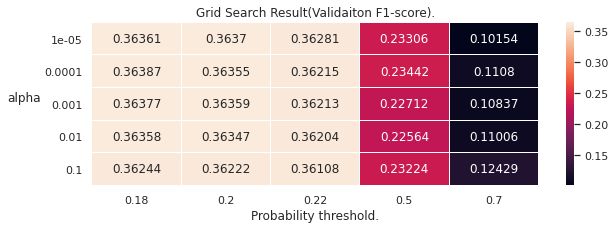

In [ ]:
plt.subplots(figsize=(10,3))
sns.heatmap(f_score_cv_list,annot=True,fmt='.5g',linewidths=0.01,
            xticklabels=prob_thresh,yticklabels=alpha_list)
plt.xlabel('Probability threshold.')
plt.ylabel('alpha',rotation=0,labelpad=20)
plt.title('Grid Search Result(Validaiton F1-score).');

In [ ]:
print("Classifier having best cross-validation F1-score:")
print('-'*50)
print(best_clf)
print('Prob threshold:'.ljust(15),best_th)
print('alpha:'.ljust(15),best_alpha)
print('Train F1-score:'.ljust(15),best_score_tr)
print('CV F1-score:'.ljust(15),best_score_cv)

Classifier having best cross-validation F1-score:
--------------------------------------------------
CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False,
                                                    class_weight='balanced',
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='log', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=-1,
                                                    penalty='elasticnet',
                                                    power_t=0.5,
                       

### Best Classifier:
- alpha = 1e-4
- Probability threshold = 0.18

In [ ]:
%%time
best_alpha = 1e-4
best_th = 0.18
clf = SGDClassifier(loss='log',
                        alpha=best_alpha,
                        class_weight='balanced',
                        penalty='elasticnet',
                        n_jobs=-1,
                        random_state=34)
    
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=0)\
            .split(dataset.loc[dataset.eval_set=='train',ftrs],
                    dataset.loc[dataset.eval_set=='train','reordered'],
                    dataset.loc[dataset.eval_set=='train','order_id'])
            
best_clf = CalibratedClassifierCV(clf,
                                    method='isotonic',
                                    cv=gss,)

best_clf.fit(dataset.loc[dataset.eval_set=='train',ftrs],
            dataset.loc[dataset.eval_set=='train','reordered'])  

CPU times: user 35.2 s, sys: 6.52 s, total: 41.7 s
Wall time: 36.8 s


In [ ]:
%%time
prob_pred = best_clf.predict_proba(dataset[ftrs])
pred = (prob_pred[:,1]>=best_th).astype(np.uint8)
dataset['log_reg_pred'] = pred

CPU times: user 7.03 s, sys: 4.27 s, total: 11.3 s
Wall time: 4.57 s


Train:


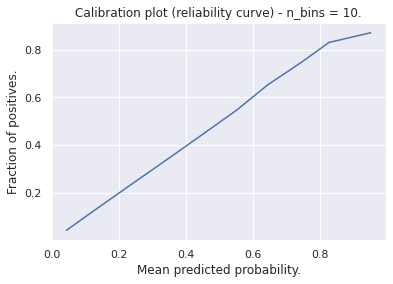

Validation:


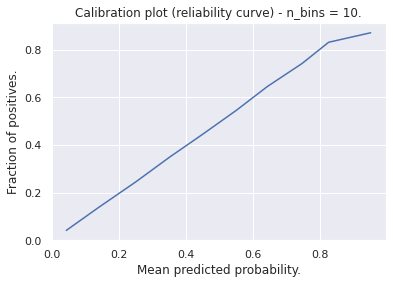

In [ ]:
# checking if probabilities are well calibrated or not
printb('Train:')
eval_set = 'train'
idx = dataset.loc[dataset.eval_set==eval_set,'eval_set'].index
n_bins=10
plot_calibration_curve(dataset.loc[dataset.eval_set==eval_set,'reordered'],
                        prob_pred[idx,1],
                        n_bins=n_bins,
                       normalize=False)
plt.show()

printb('Validation:')
eval_set = 'cv'
idx = dataset.loc[dataset.eval_set==eval_set,'eval_set'].index
n_bins=10
plot_calibration_curve(dataset.loc[dataset.eval_set==eval_set,'reordered'],
                        prob_pred[idx,1],
                        n_bins=n_bins,
                       normalize=False)
plt.show()

> Calibration curve is an almost straight line. Hence, the probabilities are well calibrated.

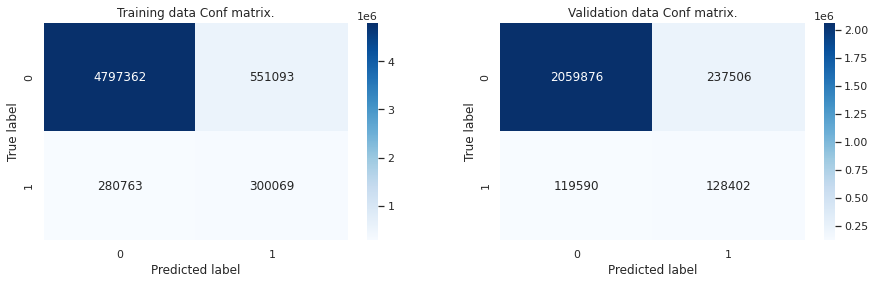

In [ ]:
# confusion matrix
fig,ax = plt.subplots(1,2,figsize=(15,4))
plot_confusion_matrix(dataset.loc[dataset.eval_set=='train','reordered'],
                 dataset.loc[dataset.eval_set=='train','log_reg_pred'],
                 title='Training data Conf matrix.',
                 ax=ax[0])

plot_confusion_matrix(dataset.loc[dataset.eval_set=='cv','reordered'],
                 dataset.loc[dataset.eval_set=='cv','log_reg_pred'],
                 title='Validation data Conf matrix.',
                 ax=ax[1])

In [ ]:
%%time
best_score_tr = f_score(dataset[dataset.eval_set=='train'],
                    target='log_reg_pred',
                    pr_re=False)       
best_score_cv = f_score(dataset[dataset.eval_set=='cv'],
                    target='log_reg_pred',
                    pr_re=False)
print('Train F1-score:'.ljust(15),best_score_tr)
print('CV F1-score:'.ljust(15),best_score_cv)

Train F1-score: 0.3653548339783208
CV F1-score:    0.36378059503346777
CPU times: user 1min 36s, sys: 7.1 s, total: 1min 43s
Wall time: 1min 36s


In [ ]:
tr_acc = accuracy_score(dataset.loc[dataset.eval_set=='train','reordered'],
                        dataset.loc[dataset.eval_set=='train','log_reg_pred'],)
cv_acc = accuracy_score(dataset.loc[dataset.eval_set=='cv','reordered'],
                        dataset.loc[dataset.eval_set=='cv','log_reg_pred'])

print(f'Train Accuracy: {tr_acc*100} %')
print(f'Validation Accuracy: {cv_acc*100} %')

Train Accuracy: 85.97038733324935 %
Validation Accuracy: 85.97078464697134 %


In [ ]:
submission(dataset[dataset.eval_set=='test'],
           target='log_reg_pred',
           msg='1st-cut Approach Log-Reg th:0.18')

100% 4.43M/4.43M [00:01<00:00, 2.49MB/s]
Successfully submitted to Instacart Market Basket AnalysisWarning: Looks like you're using an outdated API Version, please consider updating (server 1.5.12 / client 1.5.4)
fileName                    date                 description                                     status    publicScore  privateScore  
--------------------------  -------------------  ----------------------------------------------  --------  -----------  ------------  
submission.csv              2021-07-01 19:01:01  1st-cut Approach Log-Reg th:0.18                complete  0.36886      0.36742       
last_order.csv              2021-07-01 16:47:38  reorders of last order as prediction            complete  0.32768      0.32763       
last_order.csv              2021-07-01 16:34:08  purchases of last order as reorder              complete  0.31180      0.31202       
random_k_prod.csv           2021-07-01 16:21:23  k most reordered prod(weighted) by user         complete  0.248

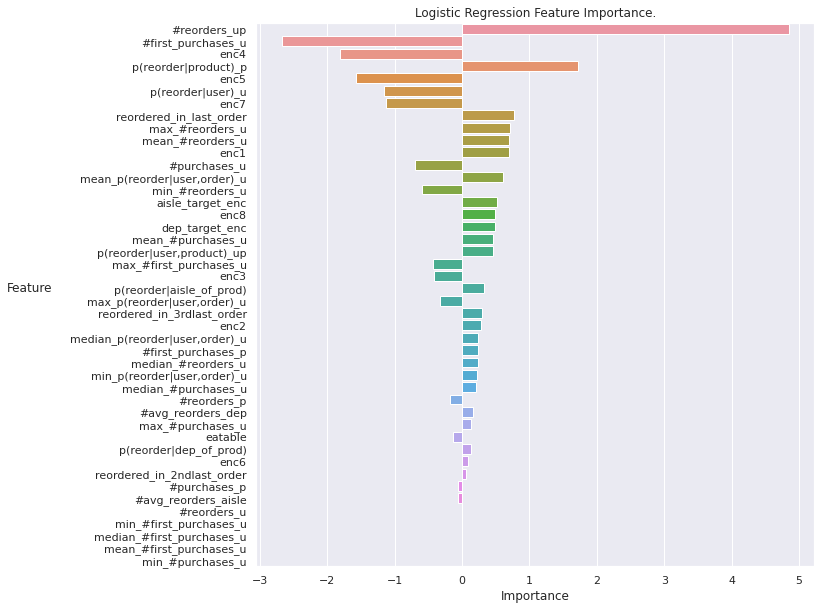

In [ ]:
ftr_imp = plot_feature_importance(best_clf.calibrated_classifiers_[0].base_estimator.coef_[0],
                                  ftrs,
                                  'Logistic Regression',
                                  figsize=(10,10),
                                  return_ftr_imp=True);

In [ ]:
# Saving
pickle.dump(best_clf,open('best_Log_Reg.pkl','wb'))

In [ ]:
best_clf = pickle.load(open('/content/best_Log_Reg.pkl','rb'))

In [ ]:
dataset.to_feather('dataset.feather')
kaggle_file_uploader(files = ['/content/dataset.feather'],
                     id = 'shubhamscifi/instacart',
                     title = 'instacart',
                     folder = 'data',
                     msg = 'dataset with log-reg prediction',
                     del_after_upload=False)

Data package template written to: data/dataset-metadata.json
Starting upload for file dataset-unscaled.feather
100% 529M/529M [00:10<00:00, 54.8MB/s]
Upload successful: dataset-unscaled.feather (529MB)
Starting upload for file dataset.feather
100% 0.99G/0.99G [00:16<00:00, 62.8MB/s]
Upload successful: dataset.feather (1014MB)
Starting upload for file dataset-prev.feather
100% 603M/603M [00:12<00:00, 50.1MB/s]
Upload successful: dataset-prev.feather (603MB)
Dataset version is being created. Please check progress at /api/v1/datasets/status/shubhamscifi/instacart




---

